In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
import numpy as np
from util import getHashId, pickleLoad

feature_selection = pickleLoad('data/feature_selection.pkl')
features_oc = np.load('data/preprocessed/features_vox.npy')
exc = 30
features = [f for f in features_oc if f not in feature_selection['excludeds'][exc][np.argmax(feature_selection['accuracies'][exc])]]

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : features,
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_glcm_Contrast_glcm_Correlation_glcm_DifferenceEntropy_glcm_DifferenceVariance_glcm_JointEnergy_glcm_JointEntropy_glcm_Imc2_glcm_Idm_glcm_MCC_glcm_Idmn_glcm_Id_glcm_Idn_glcm_InverseVariance_glcm_MaximumProbability_glcm_SumEntropy_glcm_SumSquares_glszm_SmallAreaEmphasis_glszm_LargeAreaEmphasis_glszm_GrayLevelNonUniformity_glszm_GrayLevelNonUniformityNormalized_glszm_SizeZoneNonUniformity_glszm_SizeZoneNonUniformityNormalized_glszm_ZonePercentage_glszm_GrayLevelVariance_glszm_ZoneEntropy_glszm_HighGrayLevelZoneEmphasis_glszm_LargeAreaLowGrayLevelEmphasis_glszm_LargeAreaHighGrayLevelEmphasis_glrlm_ShortRunEmphasis_glrlm_LongRunEmphasis_glrlm_GrayLevelNonUniformity_glrlm_GrayLevelNonUniformityNormalized_glrlm_RunLengthNonUniformity_glrlm_RunLengthNonUniformityNormalized_glrlm_RunPercentage_glrlm_GrayLevelVariance_glrlm_RunVariance_glrlm_RunEntropy_glrlm_LowGrayLevelRunEmphasis_glrlm_HighGrayLevelRunEmphasis_glrlm_ShortR

In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4629816, 558)
(4629816, 8)
validation
(621056, 558)
(621056, 8)
test
(624904, 558)
(624904, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 558)]             0         


 dense (Dense)               (None, 1024)              572416    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1262472 (4.82 MB)


Trainable params: 1262472 (4.82 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

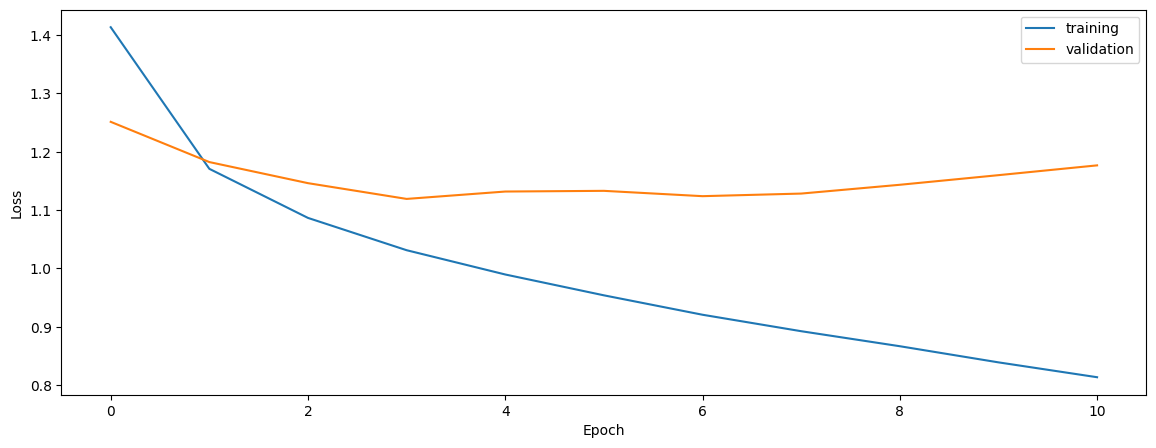

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6092816647573035
0.551750566776587
0.5920157336166835


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.5692095369286698
0.5458083122629582
0.5236732465010921


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.5664738282681182
0.5560189573459715
0.5229343578047674


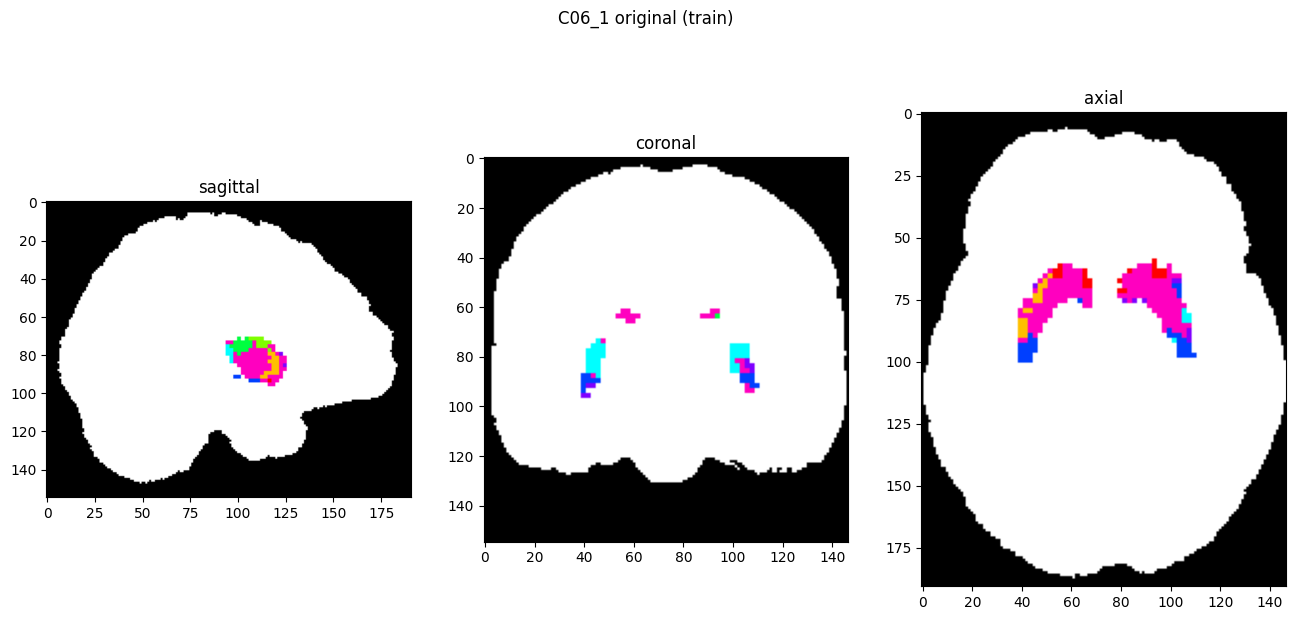

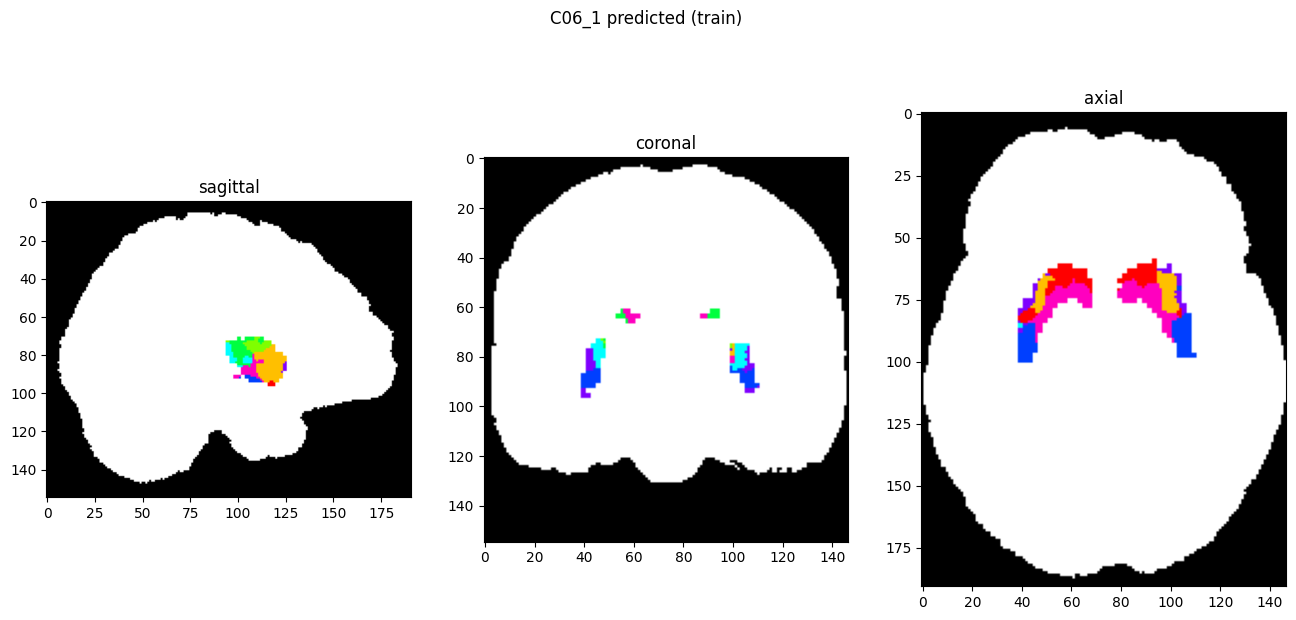

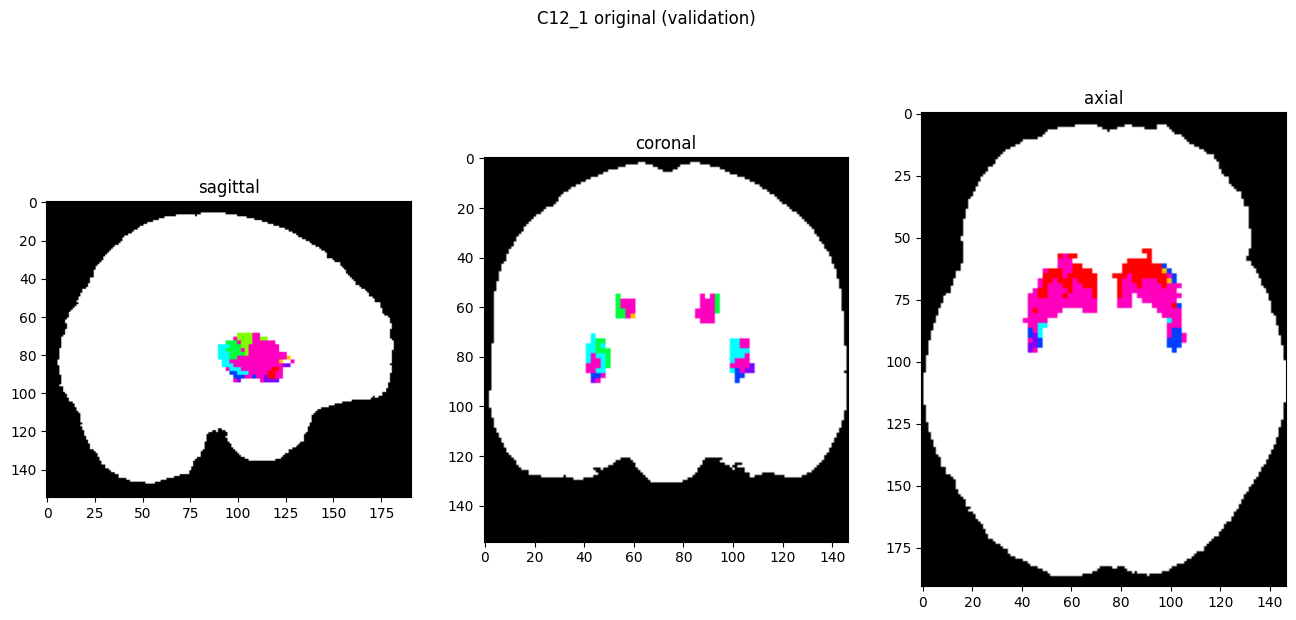

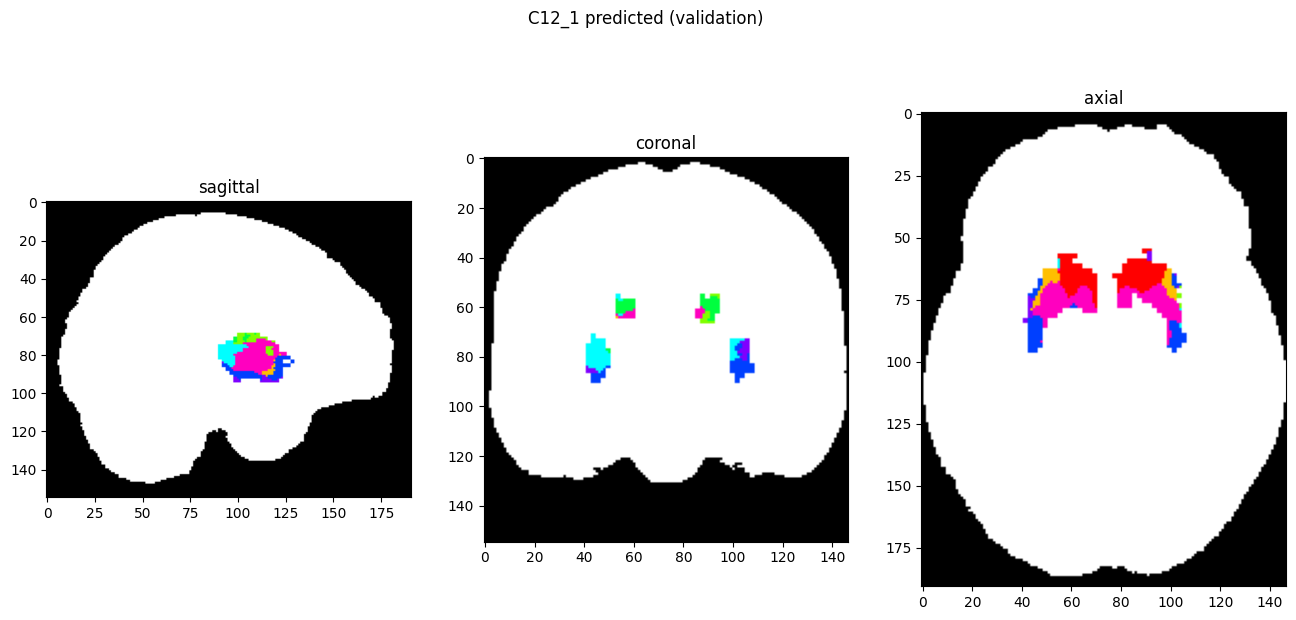

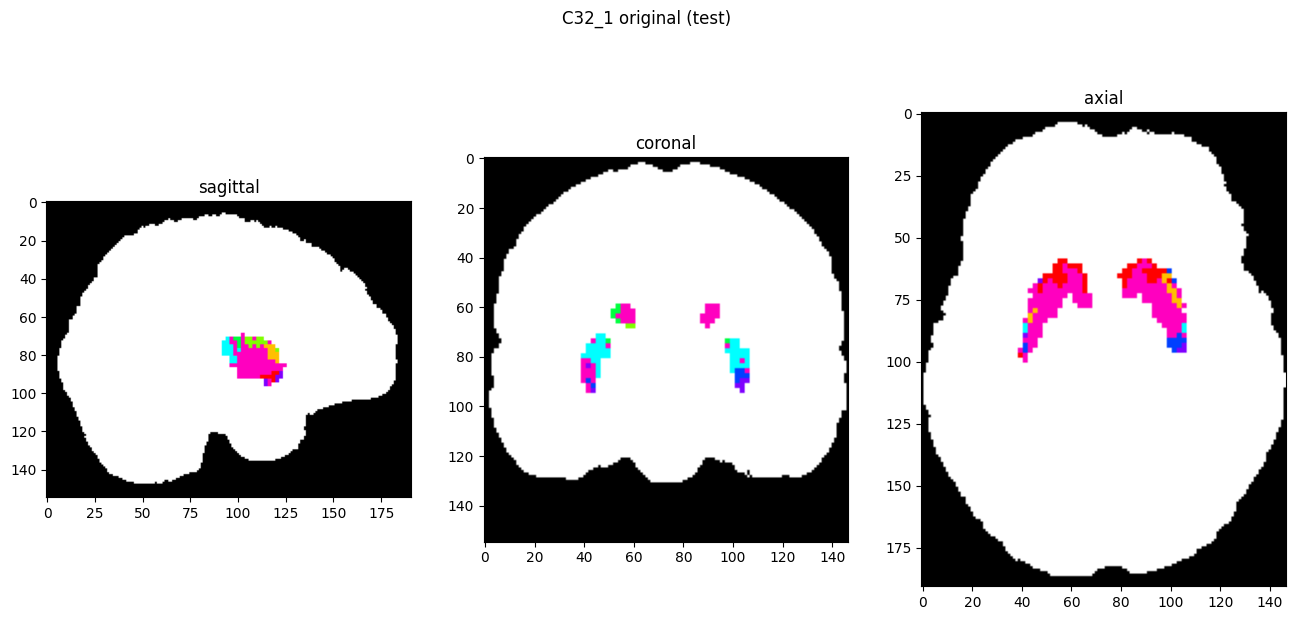

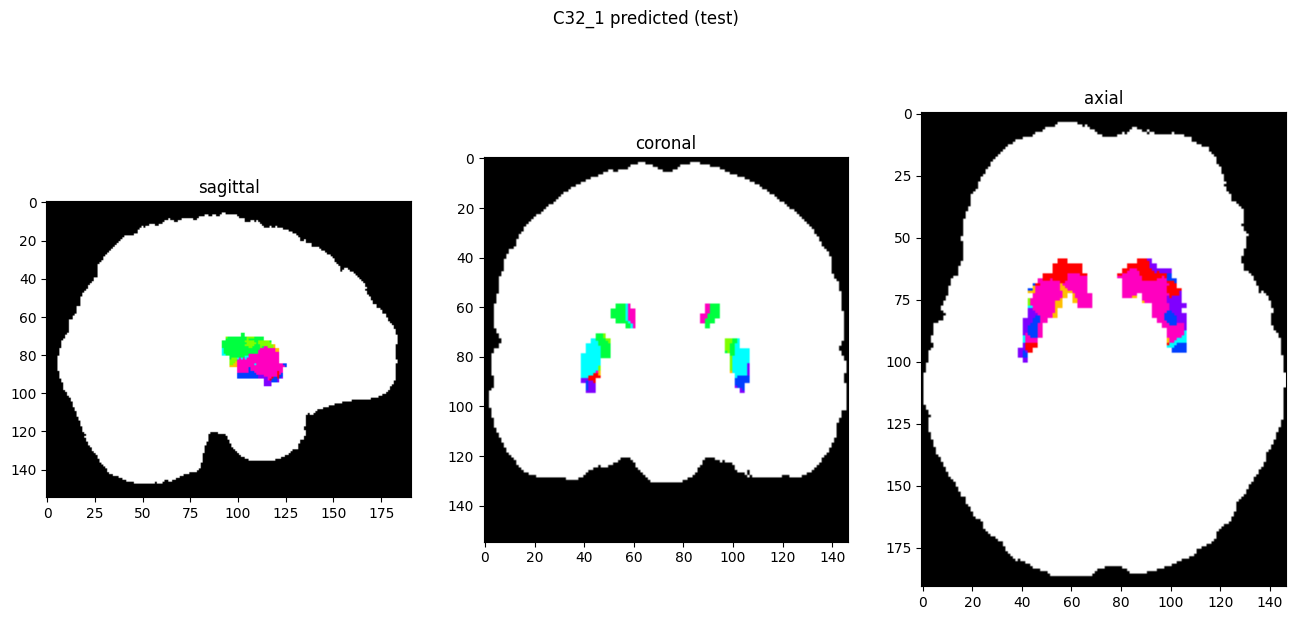

In [10]:
showResults(model, gen, threshold=0)